<a href="https://colab.research.google.com/github/Timo-Asif/Animated-PDEs/blob/main/Animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animated Solutions to Coupled PDEs

During my formulation of a solution of a large Scientific Computing assignment in C, I realised that it would be very difficult to analyse my results without a nice way to visualise them. 

To tackle this, I first looked at MATLAB to try quickly plot my results using 3D scatter plots. This worked well for its purpose, but it felt a bit incomplete as the true behaviour of the solutions arise when viewed as a pair of functions changing in time. 

Since I had more experience creating visualisations within Python, I looked into creating some animated GIFs. I found that the `matplotlib.Animation` was a very good fit for my problem as I could control what goes into each frame of my animation due to how my output files are set up.

## Problem Specification

I use a stable finite difference scheme to solve the pair of coupled partial differential equations 

$$ \frac{\partial U}{\partial t} + C \frac{\partial U}{\partial x} = 0 
\\ \frac{\partial V}{\partial t} = \gamma (U - V) $$

on an one-dimensional domain $ x \in [0, L] $, as an initial value problem with initial conditions 

$$ U(x,0) = e^{ \cos{\left[ 2\pi x/L \right]} } \\
V(x,0) = 0$$

and periodic boundary conditions 

$$U(x + L, t) = U(x, t) \\ V(x + L,t) = V(x,t).$$


This problem begins with a regular advection/transport equation in $U(x,t)$, which just simply acts to transport the initial condition $U(x,0)$ along the $x$-axis, over time $t$.

However, the inclusion of the second PDE, controlled by **two** dependent variables $U(x,t)$ and $V(x,t)$ creates a very interesting combination where the second PDE ends up 'influencing' the behaviour of the first, despite it being completely independent of $V(x,t)$. The resulting final behaviour indicates a decaying action on $U(x,t)$, which when animated one can see how the parameters $C$ and $\gamma$ affect the 'strength' of this decay.


## Solution

Given an input file `input.txt` of variables, I solved the problem in C using the well known (and stable) Upwinding Scheme, with a dynamically set timestep via the Courant–Friedrichs–Lewy condition $ \delta t = \delta x/C $ to ensure a stable output at all times.

The input file contains the values of the variables
* $C \in \mathbb{R_{\geq 0}},$ the Advection Velocity, 
* $\gamma \in \mathbb{R_{\geq 0}},$ the decay rate on the second PDE
* $L \in \mathbb{R_{\geq 0}},$ the length of the $x$-domain
* $n_x \in \mathbb{N_{>0}},$ the number of points sampled at each timestep
* $t_F \in \mathbb{R_{\geq 0}},$ the end-time of the simulation

The output produced by my solution in C is a `.txt` or a `.dat` file containing the values of $t, x, U(x,t),$ and $ V(x,t)$ over the time domain $t \in [0, t_F]$. 

In [1]:
# Initial imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as mpatches

# Loading in Files

In [2]:
# Load Parameters (inputs) File
inputs = 'input.txt' # Parameters for finite difference scheme
params = np.loadtxt(inputs)

# Load Output File
outputs = 'DefaultOutput.dat' # Results
data = np.loadtxt(outputs)

# Title for final GIF file depending on outputs
gif_title = outputs[:-4]+'_GIF.gif'

In [3]:
# Input Parameters
C = params[0]
gamma = params[1]
L = params[2] # Used to define axes
nx = int(params[3]) # Used to define number of points for each frame
t_F = params[4]
output_timestep = params[5]

print(params)

[ 1.   1.   5.  40.  20.   0.4]


In [4]:
# Assigning Output data to Arrays
t = data[:,0]
x = data[:,1]
U = data[:,2]
V = data[:,3]

In [5]:
# Viewing the size of arrays to ensure files were loaded correctly
n_elem = U.size # Later used to define number of frames
print(n_elem)

2040


# Initialising Plot

Initial Conditions U(x,0) and V(x,0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


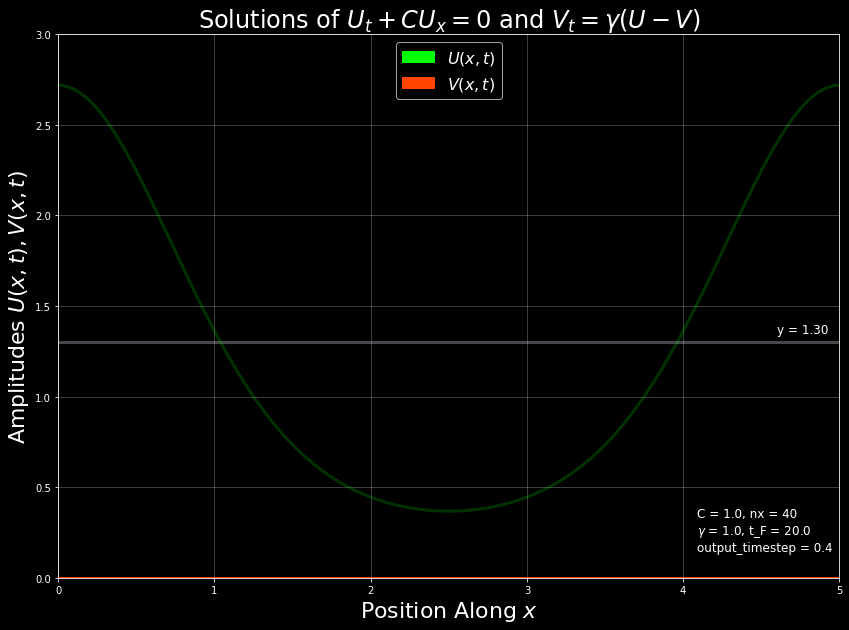

In [6]:
# Initialise Plot
plt.style.use("dark_background")
fig = plt.figure(figsize=(14,10))
plt.title(r'Solutions of $U_t + CU_x = 0$ and $V_t = \gamma(U - V)$',fontsize=24)

# Initial Conditions 
xi = np.linspace(0,5,1000)
plt.plot(xi,np.exp(np.cos(2*np.pi*xi/5)), 
         linewidth=3, color='lime', alpha=0.2)
plt.plot(xi, xi*0, 
         linewidth=3, color='orangered', alpha=1)

# Limit as t->inf
graphlim = 1.30
plt.hlines(graphlim, 0, 5, 
           color='lavender', alpha=0.3, linewidth=3)

# Axis/Grid Setup
ax = plt.axes()
ax.grid(True, alpha=0.3)
plt.xlabel(r"Position Along $x$", fontsize=22)
plt.ylabel(r'Amplitudes $U(x,t), V(x,t)$', fontsize=22)

# Parameters
paramstring = f'C = {C:.1f}, nx = {nx}\n'
outputparam = f'output_timestep = {output_timestep:.1f}'
ax.text(4.09, 0.15, paramstring + r'$\gamma$ = ' 
        + f'{gamma:.1f}, t_F = {t_F:.1f}\n' + outputparam, fontsize=12)

# Stabilise Line
ax.text(4.6,1.35,f'y = {graphlim:.2f}', fontsize=12)

# Set Graph Axes
ax.set_xlim([0, L])
ax.set_ylim([0, 3])

# Legend Entries
U_col = 'lime'
V_col = 'orangered'
U_patch = mpatches.Patch(color=U_col, label=r'$U(x,t)$')
V_patch = mpatches.Patch(color=V_col, label=r'$V(x,t)$')
plt.legend(handles=[U_patch, V_patch], fontsize=16, loc='upper center')

# Initial Conditions Graph
print("Initial Conditions U(x,0) and V(x,0)")

# Animation Function

In [7]:
# Animation Function

# Initialise Scatter Plot Objects
plots1 = []
plots2 = []
times = []

def animate(i):
  global plots1, plots2, times
  # First remove all old scatters
  for plot in plots2:
    plot.remove()
  for plot in plots1:
    plot.remove()
  for time in times:
    time.remove()

  plots1 = []
  plots2 = []
  times = []
  # Now draw new scatters
  # Scatter Plot for U(x,t)
  plots1.append(ax.scatter(x[nx*i:nx*(i)+nx-1],
                           U[nx*i:nx*(i)+nx-1],
                           color=U_col,s=25, label='U(x,t)'))

  # Scatter Plot for V(x,t)
  plots2.append(ax.scatter(x[nx*i:nx*(i)+nx-1],
                          V[nx*i:nx*(i)+nx-1],
                          color=V_col,s=25, label='V(x,t)'))  
    
  # Updating Time Legend
  T = 0.4*i 
  string = f'{T:.1f}s'
  times.append(ax.text(4.09, 2.85, r'Time $t =$' + string, fontsize = 14))
    

# Creating the Animation

In [8]:
# Create Animation

# Frame Settings
slow_motion_factor = 5
fps = 50
interval = 1 / fps

anim = FuncAnimation(fig, animate, frames=int(n_elem/nx), 
                     interval= 1000 * interval * slow_motion_factor, 
                     blit=False)
plt.show()

# Save as gif file
anim.save(gif_title, writer = "pillow", fps=20 )

#Jupyter Notebook/Colab inline animations
plt.rcParams['animation.html'] = 'jshtml'
anim

# First a static output of t=0 will be shown, then after a few seconds an animated output will be shown